# Uncertainty quantification 

In this notebook, we exemplify an uncertainty quantification (UQ) method as outlined in the paper "Uncertainty quantification, propagation and characterization by Bayesian analysis combined with global sensitivity analysis applied to
dynamical intracellular pathway models" by Eriksson and Jauhiainen et al. 

The purpose of inverse uncertainty quantification is to estimate unknown parameters of a model from observed data, and at the same time quantify the uncertainty in these parameter estimates. We do this in a Bayesian framework by characterizing
the posterior distribution of the parameters via Approxiamte Bayesian Computation (ABC) coupled to Markov chain Monte Carlo (MCMC). 


## Prerequisites

In order to run this notebook, you need to have an R kernel installed, and the following packages installed within your R distribution: ggplot2, gridExtra, repr, ks, VineCopula, MASS, R.utils, reshape2. 

In [1]:
oldw <- getOption("warn")
options(warn = -1) # to temporarily suppress warnings

library(ggplot2)
library(gridExtra)
library(repr)
library(ks)
library(VineCopula)
library(MASS)
suppressMessages(
    library(R.utils))
library(reshape2)

options(warn = oldw)

## The model

We exemplify the approach by applying it to a relatively large model relevant for synaptic plasticity. The model exemplifies in a simplified way a molecular mechanism important for the strengthening (long term potentiation, LTP) or weakening (long term
depression, LTD) of neuronal synapses (Nair et al., 2014). The modification
of synapses through the process of LTP or LTD is here effectuated by the balance due to the interaction between calcium (Ca), calmodulin (CaM), which contains four Ca-binding domains, protein phosphatase 2B (PP2B, also known as Calcineurin), Ca/CaM-dependent protein kinase II (CaMKII) and protein phosphatase 1 (PP1). 


<img src="Images/model.png" width=360/>

The model is described by the nonlinear system:

\begin{alignat}{3} 
&\dot{\mathbf{x}}(t) &&= f(\mathbf{x}(t), \mathbf{u}(t), \mathbf{p}) \nonumber \\
&\mathbf{x}(t_0) &&=\mathbf{x_0} \label{eq:model}\\
&\mathbf{y}(t) &&= g(\mathbf{x}(t),\mathbf{s}) \nonumber
\end{alignat}

where $\mathbf{x}(t)$ corresponds to internal state variables, $\mathbf{u}(t)$ to external input, $\mathbf{y}(t)$ are the outputs, $\mathbf{p}$ are system parameters, and $\mathbf{s}$ are parameters for the readouts, like scaling factors. It can be noted that the parameters $\mathbf{\theta}=(\mathbf{p}, \mathbf{s})$ together with the initial conditions $\mathbf{x}(t_0)$ and the input $\mathbf{u}(t)$ fully specify the output from the system.

## Experimental data

When experimental data are available corresponding to all or a subset of the system outputs, we denote these data $\mathbf{y}^\text{exp}_u$, where the index $u$ indicates a specific input vector. 

We use three datasets to illustrate the UQ methodology. The data correspond to different experimental setups describing different, experimentally engineered, phenotypes of the system. The phenotypes correspond to a subpart of the system, and in the model, the experimental phenotypes are recreated by applying different model inputs $u$. The experimental data were collected from a number of publications as described in Nair et al., 2014.

The three datasets corresponding to different model pehenotypes can be loaded and plotted as follows.

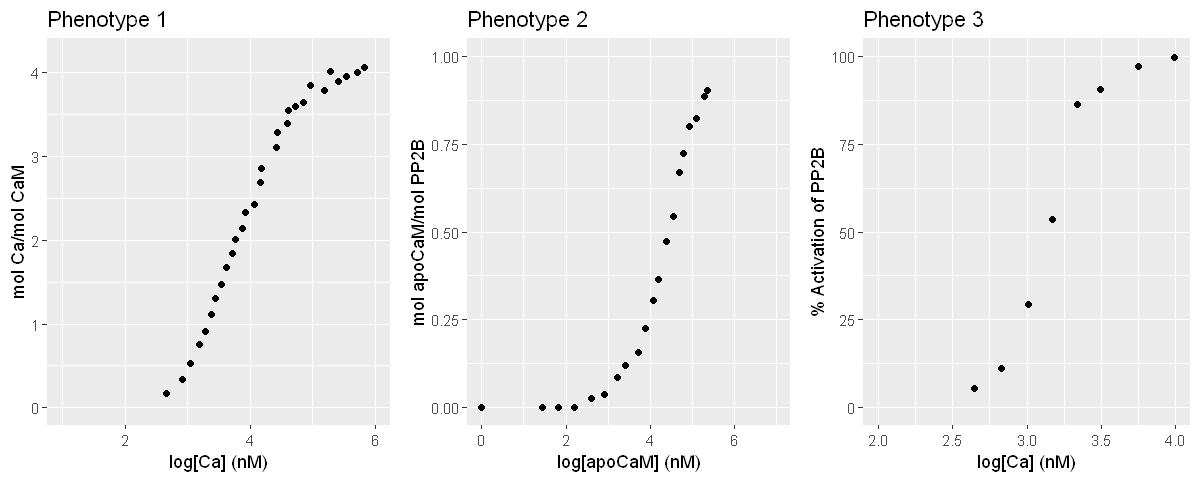

In [2]:
options(repr.plot.width=10, repr.plot.height=4)
source('loadTargets.R') # functions to load experimental data

# load targets
out <- loadTargets()
xtarget <- out$xtarget
ytarget <- out$ytarget
rm(out)

# set plot labels
xlabs <- c("log[Ca] (nM)", "log[apoCaM] (nM)", "log[Ca] (nM)")
ylabs <- c("mol Ca/mol CaM", "mol apoCaM/mol PP2B", "% Activation of PP2B")

# plot
p1 <- qplot(xtarget[[1]], ytarget[[1]], xlab=xlabs[1], ylab=ylabs[1], ylim=c(0,4.2), xlim=c(1,6), main="Phenotype 1")
p2 <- qplot(xtarget[[2]], ytarget[[2]], xlab=xlabs[2], ylab=ylabs[2], ylim=c(0,1), xlim=c(0,7), main="Phenotype 2")
p3 <- qplot(xtarget[[3]], ytarget[[3]], xlab=xlabs[3], ylab=ylabs[3], ylim=c(0,100), xlim=c(2,4), main="Phenotype 3")

grid.arrange(p1, p2, p3, nrow = 1)


## Simulating from the model

The different phenotypes correspond to situations either very close to steady state or with slow dynamics. We have utilized this by performing steady state reduction to the model in order to speed up calculations, resulting in analytical steady state solutions for subparts of the model. 

The code below expemplifies how to simulate outputs from the model for different pehnotypes. We define default parameters for the model for all tunable parameters, although for the experimental datasets used in this setting, only a subset of the parameters are relevant (i.e. affect the outputs of interest), which we index with a vector.  

We refer to the simulated model outputs for a specific input vector $u$ as $\mathbf{y}_u^{sim}$.

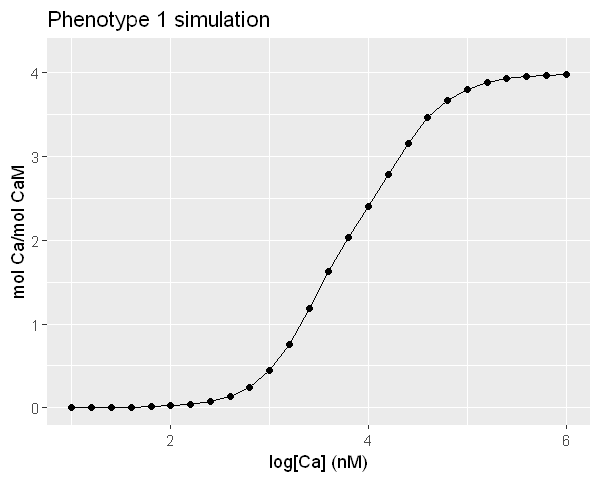

In [11]:
source('runModel.R')
source('SSsolutions.R')
options(repr.plot.width=5, repr.plot.height=4)

# default parameters and values from model
parVal <- c(0.0021524, 0.0088968, 0.028311, 0.041046, 0.046, 0.046, 0.046, 
            0.046, 0.046, 0.0016667, 0.016667, 0.008125, 0.092857, 15836, 
            22959, 1124, 4646, 0.028, 70, 800, 60, 600, 0.021, 0.04, 0.02, 
            0.002, 0.0044, 0.021, 0.021, 0.021, 0.021, 52, 2000, 4000, 5000, 
            2272.7, 0.04, 0.011, 0.011, 0.011, 0.011, 0.02, 0.002, 0.011, 
            0.0044, 2000, 4000, 5000, 2272.7, 0.73, 50, 0.05, 10, 10)

parNames <- c("kf*CaM*Ca", "kf*CaM_Ca1*Ca", "kf*CaM_Ca2*Ca", "kf*CaM_Ca3*Ca", 
              "kf*CaM*PP2B", "kf*CaM_Ca1*PP2B", "kf*CaM_Ca2*PP2B", "kf*CaM_Ca3*PP2B", 
              "kf*CaM_Ca4*PP2B", "kf*PP2B_CaM*Ca", "kf*PP2B_CaM_Ca1*Ca", "kf*PP2B_CaM_Ca2*Ca", 
              "kf*PP2B_CaM_Ca3*Ca", "KD*CaM_Ca3*Ca", "KD*CaM_Ca2*Ca", "KD*CaM_Ca1*Ca", 
              "KD*CaM*Ca", "KD*CaM_Ca4*PP2B", "KD*PP2B_CaM_Ca3*Ca", "KD*PP2B_CaM_Ca2*Ca", 
              "KD*PP2B_CaM_Ca1*Ca", "KD*PP2B_CaM*Ca", "kf*CaM*CaMKII", "kf*CaMKII_CaM_Ca3*Ca", 
              "kf*CaMKII_CaM_Ca2*Ca", "kf*CaMKII_CaM_Ca1*Ca", "kf*CaMKII_CaM*Ca", 
              "kf*CaM_Ca1*CaMKII", "kf*CaM_Ca2*CaMKII", "kf*CaM_Ca3*CaMKII", 
              "kf*CaM_Ca4*CaMKII", "KD*CaM_Ca4*CaMKII", "KD*CaMKII_CaM_Ca3*Ca", 
              "KD*CaMKII_CaM_Ca2*Ca", "KD*CaMKII_CaM_Ca1*Ca", "KD*CaMKII_CaM*Ca", 
              "kf*pCaMKII_Ca3*Ca", "kf*CaM*pCaMKIIaut", "kf*CaM_Ca1*pCaMKIIaut", 
              "kf*CaM_Ca2*pCaMKIIaut", "kf*CaM_Ca3*pCaMKIIaut", "kf*pCaMKII_Ca2*Ca", 
              "kf*pCaMKII_Ca1*Ca", "kf*CaM_Ca4*pCaMKIIaut", "kf*pCaMKII_Ca0*Ca", 
              "KD*pCaMKII_Ca3*Ca", "KD*pCaMKII_Ca2*Ca", "KD*pCaMKII_Ca1*Ca", 
              "KD*pCaMKII_Ca0*Ca", "KD*CaM_Ca4*pCaMKIIaut", "kautMax", "kf*PP1*pCaMKIIaut", 
              "kr*PP1*pCaMKIIaut", "kcat*PP1*pCaMKIIaut")

# parameters relevant for phenotypes 1-3
parIdx <- c(14, 15, 16, 17, 18, 19, 20, 21, 22) 
parNames <- parNames[parIdx]

# model input values
np <- 26
xA <- seq(1,6,length.out = np) # phenotype 1
xB <- seq(0,7,length.out = np) # phenotype 2
xC <- seq(2,4,length.out = np) # phenotype 3

# relevant parameters on log10-scale
pars <- log10(parVal[parIdx])

out <- runModel(pars, parIdx, 10^xA, "A")
qplot(out$xx, out$yy, geom=c("point", "line"), xlab=xlabs[1], ylab=ylabs[1], ylim=c(0,4.2), xlim=c(1,6), main="Phenotype 1 simulation")


The default parameter set is just one set of parameters that adequately reproduce the experimental data, without any uncertainty measures to the parameter estimates attached. We are interested in understanding which range of parameters reproduce the experimental data.  

We can use the model and the experimental data to perform the calibration and we proceed with defining priors for the parameters of interest. We use the default values of the parameters to define wide uniform priors on the log10-scale. 

In [4]:
# scale to determine prior values
scale <- 1000

# prior
ll = parVal[parIdx]/scale
ul = parVal[parIdx]*scale
ll = log10(ll) # log10-scale
ul = log10(ul) # log10-scale

## ABC-MCMC with copulas

In ABC, samples from a prior distribution (or a proposal distribution) are accepted if the experimental data are reproduced by simulations from the model within a certain margin, so that a distance measure $\rho(S(\mathbf{y}^{sim}),S(\mathbf{y}^\text{exp}))$ is smaller than some predefined cut-off $\delta$ (S is a summary statistic of the data). The accepted parameter sets $\mathbf{\theta}$ will form the approximate posterior distribution $f(\mathbf{\theta}|\rho(S(\mathbf{y}^\text{exp}),S(\mathbf{y}^{sim}))\leq\delta)$. 

We use a distance measure, or scoring function, that accounts for deviations on both the model output (y-axis) and model input (x-axis) since the experimental data may be subject to experimental error both regarding input and output.  

We couple ABC to Markov chain Monte Carlo (MCMC) to efficiently sample from the posterior distribution of the parameters of interest. The model is fitted to the datasets in sequence. In order to incorporate the information from each fit, we do the following:

* Fit the model to one datataset, producing a posterior distribution
* Fit a copula to the posterior distribution 
* Use the copula as a prior to fit the model to the next dataset

We use graphical models called R-vines to formulate copulas that are constructed in pairs in order to describe the dependencies over multiple parameters. 



### Copulas

Copulas are multivariate probability distributions which describe the dependence structure between stochastic variables. The copula is a function that connects the multivariate distribution function to the marginal ones ($F_i$) as follows.

$$
F(\mathbf{x}) = C(F_1(x_1), \ldots, F_d(x_d))
$$ 

It can be shown that the multivariate (joint) density can be represented by a number of appropriate pair-copulas times the conditional marginal densities based on a pair-copula factorization. For a distribution over three variables, we have

$$
f(x_1, x_2, x_3) = c_{1,2}(F_1(x_1),F_2(x_2))c_{2,3|1} (F(x_2|x_1), F(x_3|x_1))c_{1,3}(F_1(x_1), F_3(x_3))f_1(x_1) f_3 (x_3) f_2(x_2)\\
$$

The copula pairs can be chosen independently of each other giving a wide range of possible dependence structures. We use graphical models called R-vines to arrange the pair copulas in a tree structure. 

Let's assume we work with a simple bivariate distribution and that we have a bivariate sample $\mathbf{x}=[\mathbf{x}_1, \mathbf{x}_2]$. For each variable $X_1$ and $X_2$, we estimate a cumulative distribution $P(X_1 \leq x_1)$ and $P(X_2 \leq x_2)$ (this can be done in R using e.g. the kcde or ecdf functions). We evaluate these cumulative densities in the sample points $[\mathbf{x}_1, \mathbf{x}_2]$ and denote this information $\mathbf{z}=[\mathbf{z}_1, \mathbf{z}_2]$. This step maps the sample points ($\mathbf{x}$) into the $[0,1]$ space and we fit a copula to $\mathbf{z}$ in this space.




### Pre-calibration

Each fit to a dataset begins with a pre-calibration step, in order to construct a covariance matrix for the MCMC transition kernel as well as finding starting points for the MCMC chains.

In the pre-calibration step we sample independently from the prior distribution a number of times ($npc$) to produce a set of samples. We generate simulated output from the model for each parameter set and check, using the distance measure, how close the simulated outputs $\mathbf{y}^{sim}$are to the experimental data $\mathbf{y}^{exp}$. We save a certain fraction $p$ of the samples that have the smallest distances. With these samples, we estimate a covariance matrix that is used as transition kernel Q (scaled appropriately) for the MCMC chains. We also pick random starting points for the chains. 

In order to perform a streamlined computational pipeline, we always formulate the prior distribution of the parameters in the form of a copula. For the fit to the first dataset, when we have uniform independent priors for all parameters, we use an independece copula, where all copula pairs (i.e. pairs of parameters) are independent. 

We start of the sequence of fitting the model to the datasets by using phenotype 1. 

In [5]:
source('ScoringFunction.R') # load scoring function with the distance measure between experimental and simulated data
source('PreCalibration.R')
source('copulaFunctions.R')

# no of samples
npc <- 50000 # pre-calibration
ns <- 1000 # no of samples required from each ABC-MCMC chain

# settings
p <- 0.01 # fraction of samples to keep in the precalibration
nChains <- 20 # number of chains to run
delta <- 0.1 # ABC acceptable distance 

set.seed(7619201)
cat("Starting run for phenotype 1.\n")

# start with independence copula for phenotype 1
out <- makeIndepCopula(ll, ul)
copula <- out$copula
U <- out$U # selected sample points 
Z <- out$Z # cumulative density at points in U, used for fitting the copula
Y <- out$Y # probability density at points in U, used to assess marginal density

# precalibration all at once
out1 <- preCalibration(10^xA, parIdx, xtarget[[1]], ytarget[[1]], npc, U, Z, copula, 'A')
sfactor <- 0.1 # scaling factor for transition kernel Q
out2 <- getMCMCPar(out1$prePar, out1$preDelta, p, sfactor, delta, nChains)
Sigma <- out2$Sigma
startPar <- out2$startPar



Starting run for phenotype 1.


### ABC-MCMC

Now we are ready to perform sampling with ABC and MCMC for phenotype 1. We input various parameters into the ABCMCMC function below, as commented in the code. 

In [6]:
source('ABCMCMCFunctions.R')
drawsA <- lapply(1:nChains, function(i) ABCMCMC(10^xA, # input u to simulation 
                                                parIdx, # index for relevant parameters
                                                ns, # number of required samples 
                                                xtarget[[1]], ytarget[[1]], # phenotype 1 experimental data
                                                startPar[i,], # starting values for MCMC chain
                                                Sigma, # covariance matrix for multivariate normal distribution used as transition kernel in MCMC
                                                delta, # ABC acceptable distance 
                                                U, Z, Y, # sample point, cumulative density, probability density for the prior
                                                copula, # R-Vine copula for the prior  
                                                'A', ll, ul))
                 
# put together
drawsA <- do.call("rbind", drawsA)
pick <- !apply(drawsA, 1, function(rw) all(rw==0))
drawsA <- drawsA[pick,]



Started chain.
Finished chain.
Started chain.
Finished chain.


We continue and run the ABC-MCMC  for phenotypes 2 and 3. 

In [7]:
##############################
## Run MCMC for phenotype 2 ##
##############################
cat("Starting run for phenotype 2.\n")

# fit copula for draws already found for phenotype 1
out <- fitCopula(drawsA, ll, ul)
copula <- out$copula
U <- out$U
Z <- out$Z
Y <- out$Y

# precalibration all at once
out1 <- preCalibration(10^xB, parIdx, xtarget[[2]], ytarget[[2]], npc, U, Z, copula, 'B')
sfactor <- 0.05 #scaling factor
out2 <- getMCMCPar(out1$prePar, out1$preDelta, p, sfactor, delta, nChains)
Sigma <- out2$Sigma
startPar <- out2$startPar

drawsB <- lapply(1:nChains, function(i) ABCMCMC(10^xB, parIdx, ns, xtarget[[2]], ytarget[[2]], startPar[i,], Sigma, delta, U, Z, Y, copula, 'B', ll, ul))

# put together
drawsB <- do.call("rbind", drawsB)
pick <- !apply(drawsB, 1, function(rw) all(rw==0))
drawsB <- drawsB[pick,]

# filter
pick <- apply(drawsB,1, function(u){out <- runModel(u, parIdx = parIdx, input = 10^xA, rInd = 'A');getMaxScore(xtarget[[1]], ytarget[[1]], out$xx, out$yy)}) <= delta
drawsB <- drawsB[pick,]  

##############################
## Run MCMC for phenotype 3 ##
##############################
cat("Starting run for phenotype 3.\n")

# fit copula for draws already found for phenotype 1,2
out <- fitCopula(drawsB, ll, ul)
copula <- out$copula
U <- out$U
Z <- out$Z
Y <- out$Y

# precalibration all at once
out1 <- preCalibration(10^xC, parIdx, xtarget[[3]], ytarget[[3]], npc, U, Z, copula, 'C1')
sfactor <- 0.05 #scaling factor
out2 <- getMCMCPar(out1$prePar, out1$preDelta, p, sfactor, delta, nChains)
Sigma <- out2$Sigma
startPar <- out2$startPar

drawsC1 <- lapply(1:nChains, function(i) ABCMCMC(10^xC, parIdx, ns, xtarget[[3]], ytarget[[3]], startPar[i,], Sigma, delta, U, Z, Y, copula, 'C1', ll, ul))

# put together
drawsC1 <- do.call("rbind", drawsC1)
pick <- !apply(drawsC1, 1, function(rw) all(rw==0))
drawsC1 <- drawsC1[pick,]

# filter
pick1 <- apply(drawsC1,1, function(u){out <- runModel(u, parIdx = parIdx, input = 10^xA, rInd = 'A');getMaxScore(xtarget[[1]], ytarget[[1]], out$xx, out$yy)}) <= delta

pick2 <- apply(drawsC1,1, function(u){out <- runModel(u, parIdx = parIdx, input = 10^xB, rInd = 'B');getMaxScore(xtarget[[2]], ytarget[[2]], out$xx, out$yy)}) <= delta

drawsC1 <- drawsC1[pick1 & pick2,]

draws <- drawsC1
outFile <- sprintf('Draws-Phenotype123-Scale%d.RData', scale)
save(draws, parNames, file=outFile)


Starting run for phenotype 2.
Started chain.
Finished chain.
Started chain.
Finished chain.
Starting run for phenotype 3.
Started chain.
Finished chain.
Started chain.
Finished chain.


We have now produced a set of parameters that reproduce the experimental data. We can simulate the ouput from the model for these parameter sets and compare the fit with the experimental data. 

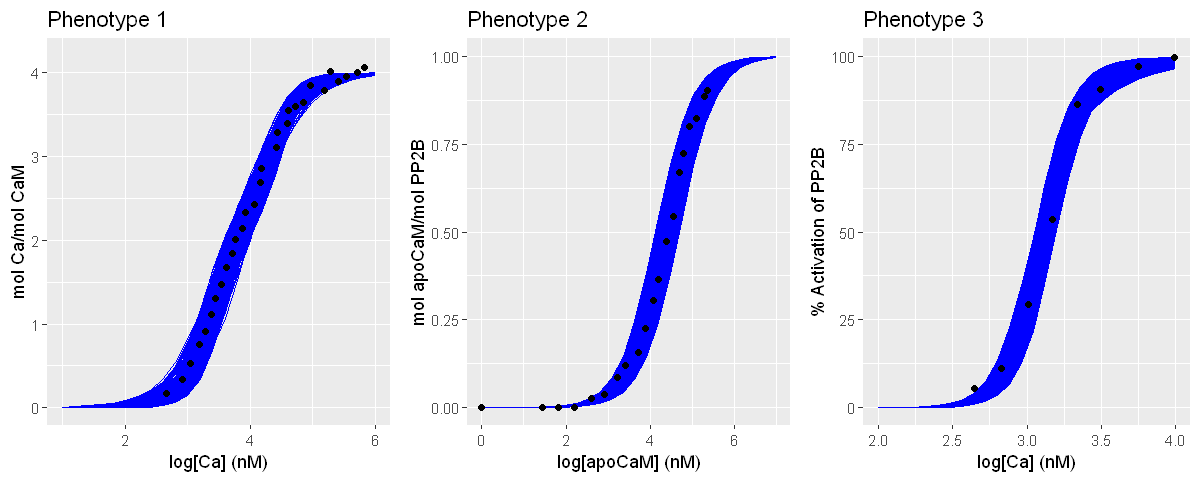

In [8]:
options(repr.plot.width=10, repr.plot.height=4)

outA <- apply(draws, 1, function(u){runModel(u, parIdx = parIdx, input = 10^xA, rInd = 'A')})
outB <- apply(draws, 1, function(u){runModel(u, parIdx = parIdx, input = 10^xB, rInd = 'B')})
outC <- apply(draws, 1, function(u){runModel(u, parIdx = parIdx, input = 10^xC, rInd = 'C1')})

dfA <- melt(lapply(outA, as.data.frame), id=c("xx", "yy"))
dfB <- melt(lapply(outB, as.data.frame), id=c("xx", "yy"))
dfC <- melt(lapply(outC, as.data.frame), id=c("xx", "yy"))

dfExpA<- data.frame(x=xtarget[[1]], y=ytarget[[1]])
dfExpB<- data.frame(x=xtarget[[2]], y=ytarget[[2]])
dfExpC<- data.frame(x=xtarget[[3]], y=ytarget[[3]])

g1 <- ggplot(dfA, aes(x=xx, y=yy, group=L1))+
  geom_line(color="blue")+
  ylim(c(0,4.2))+
  xlim(c(1,6))+
  labs(y=ylabs[1], x=xlabs[1], title="Phenotype 1")+
  geom_point(data=dfExpA, aes(x=x, y=y), inherit.aes=FALSE)

g2 <- ggplot(dfB, aes(x=xx, y=yy, group=L1))+
  geom_line(color="blue")+
  ylim(c(0,1))+
  xlim(c(0,7))+
  labs(y=ylabs[2], x=xlabs[2], title="Phenotype 2")+
  geom_point(data=dfExpB, aes(x=x, y=y), inherit.aes=FALSE)

g3 <- ggplot(dfC, aes(x=xx, y=yy, group=L1))+
  geom_line(color="blue")+
  ylim(c(0,100))+
  xlim(c(2,4))+
  labs(y=ylabs[3], x=xlabs[3], title="Phenotype 3")+
  geom_point(data=dfExpC, aes(x=x, y=y), inherit.aes=FALSE)

grid.arrange(g1, g2, g3, nrow = 1)


